<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2022TeamA/blob/main/COVID_Procedures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading of the Datawarehouse and programs

In [2]:
# install the newest version 
!pip3 install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     / 25.9 MB 679 kB/s
     |████████████████████████████████| 10.9 MB 10.4 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
     |████████████████████████████████| 102 kB 12.1 MB/s 
     |████████████████████████████████| 675 kB 66.0 MB/s 
     |████████████████████████████████| 4.7 MB 40.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 812 kB 47.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=f58dce53ae6532996427e6797ea42ce0f9dfc59b1dd56c8ec112452d2e0e3476
  Stored in directory: /tmp/pip-ephem-wheel-cache-2659qh44/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=7ccd1ba23b997ded6b90769f4e63564a2016bb655ab23801e8f21b88e7afce5b
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b1

In [3]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
from google.colab import drive
# mount drive to access database
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
material_path = "/gdrive/Shareddrives/Gruppe A"

In [7]:
!ls "/content/gdrive/Shareddrives/Gruppe A/Datawarehouse.db"

'/content/gdrive/Shareddrives/Gruppe A/Datawarehouse.db'


In [8]:
# datawarehouse path
DB_DWH_PATH = f"/content/gdrive/Shareddrives/Gruppe A/Datawarehouse.db"
print("Datawarehouse: ", DB_DWH_PATH)
# connect to db
dwh_conn = sqlite3.connect(DB_DWH_PATH)

Datawarehouse:  /content/gdrive/Shareddrives/Gruppe A/Datawarehouse.db


In [9]:
# list of tables in db
if dwh_conn is not None:
  dwh_cursor = dwh_conn.cursor()
  dwh_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
  print("List of Tables", dwh_cursor.fetchall())

List of Tables [('Zentrum',), ('dimObservations',), ('dimEncounters',), ('dimProcedures',), ('dimConditions',), ('dimPatients',)]


In [10]:
# Read sqlite query results into a pandas DataFrame

# Zentrum Tabelle
df_Zentrum = pd.read_sql_query("SELECT * FROM Zentrum", dwh_conn)

# demographic data
df_patients = pd.read_sql_query("SELECT * FROM dimPatients", dwh_conn)
# diagnoses data
df_conditions = pd.read_sql_query("select * from dimConditions", dwh_conn)

# procedure data
# df_careplans = pd.read_sql_query("select * from careplans_info", dwh_conn)
df_procedures = pd.read_sql_query("SELECT * FROM dimProcedures", dwh_conn)

# observations
df_observations = pd.read_sql_query("SELECT * FROM dimObservations", dwh_conn)

# encounters
df_encounters = pd.read_sql_query("SELECT * FROM dimEncounters", dwh_conn)

In [11]:
# Join zwischen dimPatients und dimProcedures
covid_procedures = pd.read_sql_query("SELECT dimPatients.dataset_origin, dimProcedures.* FROM dimProcedures LEFT JOIN dimPatients ON dimPatients.id=dimProcedures.patient_id", dwh_conn)

In [12]:
covid_procedures.head()

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
0,allergy,2012-12-12T14:56:19Z,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,f222d3d6-d9f0-3586-70d4-69a77f16b58c,73761001,Colonoscopy
1,allergy,2015-05-04T11:40:19Z,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,c57b93a2-0302-4965-9e2c-713b84e7c24b,430193006,Medication Reconciliation (procedure)
2,allergy,2017-12-11T15:25:19Z,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,11306017-08e3-1375-fc44-1265a8114949,73761001,Colonoscopy
3,allergy,2019-01-30T11:40:19Z,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,cd0f83e5-1e70-75ec-1be9-b254e2589e49,23426006,Measurement of respiratory function (procedure)
4,allergy,2019-05-27T11:40:19Z,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,bdeb0bc4-50bc-5aaa-ab7f-e43535a01bbe,430193006,Medication Reconciliation (procedure)


In [13]:
# number of patients in procedure table
covid_procedures.groupby(["PATIENT_ID"]).size()

PATIENT_ID
0033cec2-67d3-39ec-b0f4-29f91a2918d6      1
003c0d44-9dfc-ca91-6121-373a8e265bd4     13
00680fcd-0ef2-99c5-f69d-59463206750f     26
00edcb46-afd4-4687-c16a-f4e20dfc3e92      2
00f4a426-4746-6513-1775-1e8650e2f6b5      1
                                       ... 
ff2d586c-f770-a795-c9eb-0b0d39447e48      1
ff5c1f25-14da-ba3a-51bb-c5735d406ea8    179
ff9e749b-0abc-22f8-0d62-6912b87781b1      1
ffd905f3-45fb-b2a7-7429-bf864ef29d81     28
ffe52b9f-cdf1-d315-9286-e64d370edde4      1
Length: 1740, dtype: int64

In [14]:
# removing covid19 dataset from covid_procedures
final_df = covid_procedures[~covid_procedures['DATASET_ORIGIN'].isin(['covid19'])]

# Basic data exploration

In [42]:
final_df.head()

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
0,allergy,2012,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,f222d3d6-d9f0-3586-70d4-69a77f16b58c,73761001,Colonoscopy
1,allergy,2015,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,c57b93a2-0302-4965-9e2c-713b84e7c24b,430193006,Medication Reconciliation (procedure)
2,allergy,2017,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,11306017-08e3-1375-fc44-1265a8114949,73761001,Colonoscopy
3,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,cd0f83e5-1e70-75ec-1be9-b254e2589e49,23426006,Measurement of respiratory function (procedure)
4,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,bdeb0bc4-50bc-5aaa-ab7f-e43535a01bbe,430193006,Medication Reconciliation (procedure)


In [56]:
# number of patients in final_df
final_df.groupby(["PATIENT_ID"]).size()

PATIENT_ID
003c0d44-9dfc-ca91-6121-373a8e265bd4     13
00edcb46-afd4-4687-c16a-f4e20dfc3e92      2
01518fe2-bd76-d1e9-a656-1e7eae35dd17      2
01581211-2e47-027b-71a0-dcbf0f4e6622      2
01a49388-c6c0-1d10-00ee-8360a11941e7      3
                                       ... 
fd4841b4-eb96-de29-c392-71785cbf1650      3
fda2e613-dd00-2f49-6e86-0c1e5c281658      2
fe55dd2f-bc68-7056-1b29-1d4c4563d30b     10
feb25ae2-c154-4c42-3276-bc6c1e337a6c      2
ff5c1f25-14da-ba3a-51bb-c5735d406ea8    179
Length: 805, dtype: int64

In [57]:
final_df.groupby(["DESCRIPTION"]).size()

DESCRIPTION
Admission to burn unit                                 1
Admission to long stay hospital                        1
Admission to orthopedic department                     8
Allergy screening test                                 6
Alpha-fetoprotein test                                44
                                                      ..
Urine protein test                                    45
Urine screening for glucose                           44
Urine screening test for diabetes                     45
Vaccination for diphtheria  pertussis  and tetanus    44
X-ray or wrist                                         3
Length: 135, dtype: int64

In [44]:
final_df.shape

(9113, 6)

In [45]:
final_df.groupby(["PATIENT_ID", "CODE"]).size()

PATIENT_ID                            CODE     
003c0d44-9dfc-ca91-6121-373a8e265bd4  180325003    7
                                      18286008     2
                                      40701008     1
                                      433112001    1
                                      73761001     2
                                                  ..
ff5c1f25-14da-ba3a-51bb-c5735d406ea8  65588006     1
                                      66348005     2
                                      714812005    1
                                      85548006     1
                                      90226004     3
Length: 3052, dtype: int64

In [74]:
final_df.groupby(["DATE"]).size()

DATE
1941      3
1956      3
1958      2
1962      3
1964      2
1966      3
1967      5
1968      9
1969      2
1970      2
1971     10
1972      3
1973      3
1974      5
1975     13
1976     17
1977     12
1978      9
1979      4
1980      3
1981      3
1982     14
1983     13
1984      6
1985     13
1986     13
1987     15
1988     10
1989     32
1990     35
1991     50
1992     30
1993     53
1994     51
1995     55
1996     90
1997     42
1998     73
1999    188
2000    169
2001    167
2002    154
2003    163
2004    169
2005    169
2006    156
2007    139
2008    134
2009     33
2010     73
2011    558
2012    637
2013    755
2014    729
2015    608
2016    599
2017    627
2018    669
2019    641
2020    865
Freq: A-DEC, dtype: int64

# Data cleaning

In [19]:
# Replace null values
final_df = final_df.replace(r'^\s*$', np.nan, regex=True)

In [20]:
# number of null values
final_df.isnull().sum()

DATASET_ORIGIN    0
DATE              0
PATIENT_ID        0
ENCOUNTER_ID      0
CODE              0
DESCRIPTION       0
dtype: int64

In [22]:
# dropping duplicate values if exists and keep first one
final_df.drop_duplicates(keep="first",inplace=True) 
print("Size of dataset after removinf duplicated rows", final_df.shape)

Size of dataset after removinf duplicated rows (9113, 6)


In [23]:
# attribute type
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9113 entries, 0 to 13569
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATASET_ORIGIN  9113 non-null   object
 1   DATE            9113 non-null   object
 2   PATIENT_ID      9113 non-null   object
 3   ENCOUNTER_ID    9113 non-null   object
 4   CODE            9113 non-null   object
 5   DESCRIPTION     9113 non-null   object
dtypes: object(6)
memory usage: 498.4+ KB


In [24]:
# change attribute type date
final_df["DATE"] = pd.to_datetime(final_df["DATE"])

In [25]:
# change date type to YYYY
final_df["DATE"] = final_df["DATE"].dt.to_period('Y')

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [26]:
final_df.head()

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
0,allergy,2012,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,f222d3d6-d9f0-3586-70d4-69a77f16b58c,73761001,Colonoscopy
1,allergy,2015,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,c57b93a2-0302-4965-9e2c-713b84e7c24b,430193006,Medication Reconciliation (procedure)
2,allergy,2017,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,11306017-08e3-1375-fc44-1265a8114949,73761001,Colonoscopy
3,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,cd0f83e5-1e70-75ec-1be9-b254e2589e49,23426006,Measurement of respiratory function (procedure)
4,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,bdeb0bc4-50bc-5aaa-ab7f-e43535a01bbe,430193006,Medication Reconciliation (procedure)


# Query of procedures broken down by year

In [58]:
# Procedure table during covid19
covid_year = final_df[final_df["DATE"] >= "2020"]
covid_year.head()

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
5,allergy,2020,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,3c7f472a-2602-bcdd-76d0-53f967923ded,261352009,Face mask (physical object)
15,allergy,2020,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,dcee0f8b-907d-69cf-c998-5e73711f2276,261352009,Face mask (physical object)
16,allergy,2020,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,61d084c0-52cc-1b9d-5ed8-505982d8f401,430193006,Medication Reconciliation (procedure)
26,allergy,2020,e92765c7-1c4b-9ee7-dbc8-5300fcb40a54,621750b5-9dd3-649c-977c-45d6315b546e,430193006,Medication Reconciliation (procedure)
54,allergy,2020,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,61c250a0-1668-e4ce-aefc-77a7842574c2,261352009,Face mask (physical object)


In [59]:
# Procedure table pre covid
pre_covid = final_df[final_df["DATE"] < "2020"]
pre_covid.head()

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
0,allergy,2012,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,f222d3d6-d9f0-3586-70d4-69a77f16b58c,73761001,Colonoscopy
1,allergy,2015,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,c57b93a2-0302-4965-9e2c-713b84e7c24b,430193006,Medication Reconciliation (procedure)
2,allergy,2017,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,11306017-08e3-1375-fc44-1265a8114949,73761001,Colonoscopy
3,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,cd0f83e5-1e70-75ec-1be9-b254e2589e49,23426006,Measurement of respiratory function (procedure)
4,allergy,2019,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,bdeb0bc4-50bc-5aaa-ab7f-e43535a01bbe,430193006,Medication Reconciliation (procedure)


In [60]:
# number of procedures during covid19 in our df
covid_year.groupby(["PATIENT_ID"]).size()

PATIENT_ID
003c0d44-9dfc-ca91-6121-373a8e265bd4    1
00edcb46-afd4-4687-c16a-f4e20dfc3e92    1
01d6dc15-6313-5327-8491-49be72f40d59    3
0302c3b7-b985-7250-8633-fd6f4c5d3ec0    1
03127a78-1c85-5b31-d4d5-14e941262148    1
                                       ..
f77e7391-8d71-066c-cb5e-a78908d32a17    1
fb6e6891-2515-b709-0435-c5fb14cf247a    4
fcda0346-ab0a-87e6-42b9-f53c11b06136    3
fe55dd2f-bc68-7056-1b29-1d4c4563d30b    1
ff5c1f25-14da-ba3a-51bb-c5735d406ea8    1
Length: 310, dtype: int64

In [61]:
# number of procedures pre covid19 in our df
pre_covid.groupby(["PATIENT_ID"]).size()

PATIENT_ID
003c0d44-9dfc-ca91-6121-373a8e265bd4     12
00edcb46-afd4-4687-c16a-f4e20dfc3e92      1
01518fe2-bd76-d1e9-a656-1e7eae35dd17      2
01581211-2e47-027b-71a0-dcbf0f4e6622      2
01a49388-c6c0-1d10-00ee-8360a11941e7      3
                                       ... 
fd4841b4-eb96-de29-c392-71785cbf1650      3
fda2e613-dd00-2f49-6e86-0c1e5c281658      2
fe55dd2f-bc68-7056-1b29-1d4c4563d30b      9
feb25ae2-c154-4c42-3276-bc6c1e337a6c      2
ff5c1f25-14da-ba3a-51bb-c5735d406ea8    178
Length: 758, dtype: int64

In [62]:
# Most often performed Procedures during covid19
covid_year['DESCRIPTION'].value_counts()[:20]

Electrical cardioversion                                                               123
Oxygen administration by mask (procedure)                                              123
Placing subject in prone position (procedure)                                          122
Face mask (physical object)                                                             90
Colonoscopy                                                                             55
Medication Reconciliation (procedure)                                                   42
Catheter ablation of tissue of heart                                                    35
Echocardiography (procedure)                                                            25
Intramuscular injection                                                                 25
Percutaneous mechanical thrombectomy of portal vein using fluoroscopic guidance         16
Controlled ventilation procedure and therapy  initiation and management (procedure)     15

In [63]:
# Most often performed Procedures pre covid19
pre_covid['DESCRIPTION'].value_counts()[:20]

Renal dialysis (procedure)                                                         1174
Electrical cardioversion                                                            970
Medication Reconciliation (procedure)                                               702
Colonoscopy                                                                         490
Evaluation of uterine fundal height                                                 387
Auscultation of the fetal heart                                                     387
Echocardiography (procedure)                                                        346
Catheter ablation of tissue of heart                                                320
Intramuscular injection                                                             191
Combined chemotherapy and radiation therapy (procedure)                             160
Percutaneous mechanical thrombectomy of portal vein using fluoroscopic guidance     134
Subcutaneous immunotherapy      

# Visualization

In [27]:
final_df.sort_values(by=['DATE'])

,DATASET_ORIGIN,DATE,PATIENT_ID,ENCOUNTER_ID,CODE,DESCRIPTION
12686,dermatitis,1941,1bb843ef-7f81-b5f0-89b6-12112988032b,ad2b46bf-c787-f75c-4544-8656b5dc6550,40701008,Echocardiography (procedure)
12687,dermatitis,1941,1bb843ef-7f81-b5f0-89b6-12112988032b,ad2b46bf-c787-f75c-4544-8656b5dc6550,415070008,Percutaneous coronary intervention
12688,dermatitis,1941,1bb843ef-7f81-b5f0-89b6-12112988032b,ad2b46bf-c787-f75c-4544-8656b5dc6550,232717009,Coronary artery bypass grafting
8008,colorectal_cancer,1956,b7ee5d7e-88cf-11d2-6fce-32c60bdb1fe4,99bd12d9-ec04-229d-4ff2-fc554b876646,40701008,Echocardiography (procedure)
8009,colorectal_cancer,1956,b7ee5d7e-88cf-11d2-6fce-32c60bdb1fe4,99bd12d9-ec04-229d-4ff2-fc554b876646,415070008,Percutaneous coronary intervention
...,...,...,...,...,...,...
1399,allergy,2020,46cdc565-e220-98df-17b2-f9080c8d7f43,ee73b39c-42e7-7920-5f7a-5f6d3bf7de53,76601001,Intramuscular injection
1398,allergy,2020,46cdc565-e220-98df-17b2-f9080c8d7f43,ed419d11-6002-5e55-962c-f25c119baf2c,430193006,Medication Reconciliation (procedure)
1397,allergy,2020,46cdc565-e220-98df-17b2-f9080c8d7f43,15e700a4-7216-784a-6dfc-a97b06d663ab,76601001,Intramuscular injection
1484,allergy,2020,560a4b1a-5d16-3a8d-144a-e5f36f801a4e,56a8eff0-e20d-4ec8-91fd-035fb2df566a,431182000,Placing subject in prone position (procedure)


In [64]:
# Start counting procedures from 2010
df_recent = final_df[final_df["DATE"] >= "2010"]

In [68]:
df_recent = df_recent.sort_values(by='DATE')

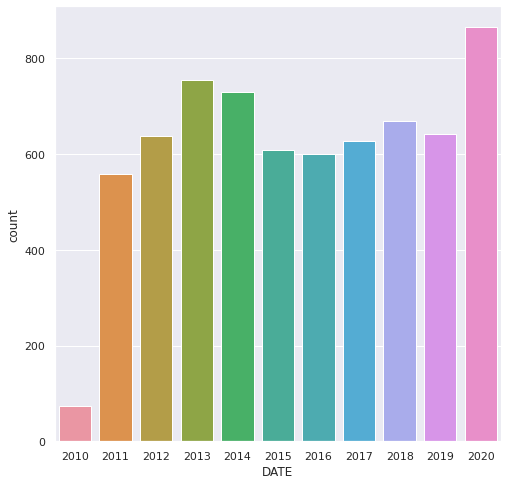

In [70]:
sns.set(rc={'figure.figsize':(8, 8)})

sns.countplot(x='DATE', data=df_recent)